In [3]:
pip install langgraph langchain-openai langchain_community Faiss-cpu langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.0 MB/s eta 0:00:00


In [4]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader,TextLoader, ArxivLoader
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq
from langchain_classic.schema import Document
from langchain_core.messages import HumanMessage, AIMessage,AnyMessage
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
import os
os.environ["GROQ_API_KEY"] = "your api key"
os.environ["OPENAI_API_KEY"] = "your api key"

In [37]:
from langchain_openai import ChatOpenAI

In [38]:
llm = ChatOpenAI(model = "gpt-4o")

In [7]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')]]

In [9]:
doc_list = [j for i in docs for j in i]
doc_list

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n'),
 Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n'),
 Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')]

In [14]:
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 20)
split_docs = splitter.split_documents(doc_list)

embedding = OpenAIEmbeddings()
vectorstore  = FAISS.from_documents(split_docs, embedding)
retriver_lg = vectorstore.as_retriever()

In [17]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool_lg=create_retriever_tool(
    retriver_lg,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [13]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]

In [16]:
docs_list = [j for i in docs for j in i]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

doc_splits = text_splitter.split_documents(docs_list)

vectorstorelangchain=FAISS.from_documents(documents=doc_splits,embedding=OpenAIEmbeddings())
retriever_lc=vectorstorelangchain.as_retriever()

In [18]:
retriever_tool_lc=create_retriever_tool(
    retriever_lc,
    "retriever_vector_db_blog",
    "Search and run information about Langcraph"
)

In [19]:
tools=[retriever_tool_lg,retriever_tool_lc]

In [20]:
tools

[Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7954f77c4400>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7954f101fbf0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x7954f77c4900>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7954f101fbf0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separa

In [21]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [39]:
llm.invoke("Hi, How are you")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 12, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CaVXPKWvbb9bn82Cf5sXh37gg9SAr', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--a6f88536-a65a-4157-b084-544cede733fd-0', usage_metadata={'input_tokens': 12, 'output_tokens': 28, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [40]:
def DeciderAgent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(model = "gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [41]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

In [50]:
def judge(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatOpenAI(model = "gpt-4o")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    print(docs)

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [52]:
from langchain import hub

In [53]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model = "gpt-4o")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [54]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(model = "gpt-4o")
    response = model.invoke(msg)
    return {"messages": [response]}

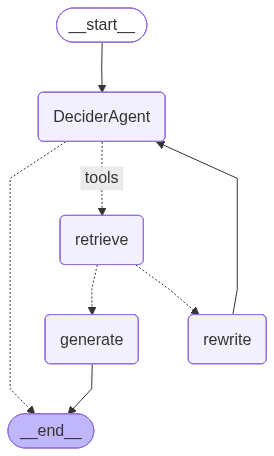

In [55]:
graph = StateGraph(AgentState)

# Define the nodes we will cycle between
graph.add_node("DeciderAgent", DeciderAgent)
retrieve = ToolNode([retriever_tool_lg,retriever_tool_lc])
graph.add_node("retrieve", retrieve)  # retrieval
graph.add_node("rewrite", rewrite)  # Re-writing the question
graph.add_node("generate", generate)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
graph.add_edge(START, "DeciderAgent")

# Decide whether to retrieve
graph.add_conditional_edges("DeciderAgent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
graph.add_conditional_edges("retrieve",judge,)
graph.add_edge("generate", END)
graph.add_edge("rewrite", "DeciderAgent")

# Compile
graph = graph.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [56]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe've raised a $125M Series B to build the platform for agent engineering. Read more.Docs by LangChain home pageLangChain + LangGraphSearch...‚åòKGitHubTry LangSmithTry LangSmithSearch...NavigationLangChainBuild a RAG agent with LangChainLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonLearnTutorialsLangChainSemantic searchRAG agentSQL agentSupervisor agentLangGraphConceptual overviewsMemoryContextGraph APIFunctional APIAdditional resourcesLangChain AcademyCase studiescloseOn this pageOverviewConceptsPreviewSetupInstallationLangSmithComponents1. IndexingLoading documentsSplitting documentsStoring documents2. Retrieval and GenerationRAG agentsRAG chainsNext stepsTutorialsLangChainBuild a RAG agent with LangChainCopy pageCopy page‚ÄãOverview

Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe've raised a $125M Series B to build the p

{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='7efd616c-7e6a-4571-aaa4-319db3ceffa5'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 96, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CaVknbf5pEzYzdJg1ytVLuo5jo63z', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--e9b57636-bd09-4b77-9924-16c5d77353c5-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'What is Langchain'}, 'id': 'call_YF8lAa1kybmYyZtLOXHGBbDT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 96, 'output_tokens': 21

In [57]:
graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe've raised a $125M Series B to build the platform for agent engineering. Read more.Docs by LangChain home pageLangChain + LangGraphSearch...‚åòKGitHubTry LangSmithTry LangSmithSearch...NavigationLangChainBuild a RAG agent with LangChainLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonLearnTutorialsLangChainSemantic searchRAG agentSQL agentSupervisor agentLangGraphConceptual overviewsMemoryContextGraph APIFunctional APIAdditional resourcesLangChain AcademyCase studiescloseOn this pageOverviewConceptsPreviewSetupInstallationLangSmithComponents1. IndexingLoading documentsSplitting documentsStoring documents2. Retrieval and GenerationRAG agentsRAG chainsNext stepsTutorialsLangChainBuild a RAG agent with LangChainCopy pageCopy page‚ÄãOverview

Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe've raised a $125M Series B to build the p

{'messages': [HumanMessage(content='What is Langgraph?', additional_kwargs={}, response_metadata={}, id='522c09bb-10ee-4a4e-95d5-f3402b6f0668'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 96, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CaVljTbPt6i7JT2YLC9cjjfIxIgHi', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--cd53d596-4626-4ee1-a166-bcd9bc5df988-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Langgraph'}, 'id': 'call_aJrcvs0R29TMVMvGeQlgThVY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 96, 'output_tokens': 19, 'total